# Natural cubic splines

In [1]:
from IPython.display import HTML, set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

Natural cubic splines (NCS) are an interpolation tool that is of interest to many applications. In interpolation problems, we are given some datapoints and want to produce a function that passes through them. One choice for achieving this would be to use a piecewise linear function, and constrain the slopes and intercepts of the piecewise linear segments, such that it passes through the datapoints. This would give a rough approximation to the underlying function. However, in many settings it may be appropriate to impose further, or different conditions on the interpolating curve. For example, we may know that the underlying function is differentiable (the piecewise linear spline is not differentiable), or that it is $n$-times differentiable and so on.

To achieve further regularity, we can choose a piecewise polynomial as the interpolating function. We can then constrain the piecewise segments to pass through the datapoints and (if necessary) to have equal derivatives at the datapoints. Such piecewise polynomials are called [splines](https://mathworld.wolfram.com/Spline.html). Cubic splines are splines in which the piecewise polynomials are of third-order. NCS have the further constraint that the curvature, that is the second derivative, of the interpolating function at the first and last point is $0$.

In particular,{cite}`kvarving2008natural` given $N$ datapoints a cubic piecewise polynomial has $N-1$ piecewise segments, each with four coeffcients, giving $4(N - 1)$ degrees of freedom. Constraining the function values, first derivatives and second derivatives to be equal for the piecewise polynomials at all points except the first and last points gives $3(N-2)$ equations. Constraining the function values to be equal to the datapoint values gives $N$ more constraints. We are left with $2$ degrees of freedom, which can be dealt in different ways, giving different spline interpolants. If we constrain the second derivatives to be zero at the first and last points, we obtain NCS. Since all the constraints are linear, solving for the coefficients of a spline interpolant is a linear equation. Because the constraints relate pairs of segments only, the matrix corresponding to these linear constraints is tri-diagonal and can therefore be solved in $\mathcal{O}(N)$ time. Below are the expressions{cite}`kvarving2008natural` for the NCS system of equations.


<div class='lemma'>
    
**Result (Natural cubic spline)** Given data $\{x_n, y_n\}_{n = 0}^N$ with $x_n < x_{n+1}$, the natural cubic spline interpolating the data in the $n^{th}$ interval $[x_n, x_{n+1}]$ is
    
$$\begin{align}
S_n(x) = &~\alpha_n (x - x_n)^3 + \beta_n (x_{n + 1} -x)^3 + \gamma_n (x - x_n) + \delta_n (x_{n + 1} - x).
\end{align}$$
    
where the constants are given by
    
$$\begin{align}
\alpha_n &= \frac{z_{n+1}}{6h_n},~~\beta_n = \frac{z_n}{6h_n},~~\gamma_n = \left(\frac{y_{n + 1}}{h_n} -  \frac{y_{n + 1}h_n}{6} \right), ~~\delta_n = \left(\frac{y_n}{h_n} - \frac{y_nh_n}{6}\right),
\end{align}$$
    
and the curvatures $z_n$ are the solution to the linear problem
    
$$\begin{align}
\begin{pmatrix}
v_1    & h_1    & 0   & \dots & 0 & 0 & 0 \\
h_1    & v_2    & h_2 & \dots & 0 & 0 & 0 \\
0      & h_2    & v_3 & \dots & \vdots & \vdots & \vdots \\
\vdots & \vdots & \vdots  & \ddots & v_{N-3} & h_{N-3} & 0 \\
0      & 0      & 0  & \dots & h_{N-3} & v_{N-2} & h_{N-2} \\
0      & 0      & 0  & \dots & 0 & h_{N-2} & v_{N-1} \\
\end{pmatrix}\begin{pmatrix}
z_{1} \\
z_{2} \\
\vdots \\
\vdots \\
z_{N-2} \\
z_{N-1} \\
\end{pmatrix}=\begin{pmatrix}
u_{1} \\
u_{2} \\
\vdots \\
\vdots \\
u_{N-2} \\
u_{N-1} \\
\end{pmatrix}
\end{align}$$
    
where $z_0 = z_n = 0$ and the linear problem is defined by
    
$$ h_n = x_{n + 1} - x_n,~b_n = \frac{1}{h_n} (y_{n + 1} - y_n),~v_n = 2 (h_n + h_{n - 1}),~u_n = 6 (b_n - b_{n - 1})$$
    

</div>
<br>


As a further motivating point, it can be shown{cite}`kvarving2008natural` that out of all curves NCS is the smoothest interpolator, where smoothness is quantified by an appropriate metric based on the second derivative of the interpolant.
    
<div class='lemma'>
    
**Result (NCS are the smoothest interpolator)** Given data $x_n, y_n \in \mathbb{R}$ for $n = 0, 1, 2, ..., N$, among all twice continuously differentiable functions functions $f : [a, b] \to \mathbb{R}$ which interpolate $\left\{x_n, y_n\right\}_{n = 0}^N$, the natural cubic spline minimises the curvature metric
    
$$ C(f) = \int^b_a \left(f''(x)\right)^2 dx. $$
    
</div>
<br>
    
Below is two functions implementing NCS. The first takes in data `x_data`, `y_data` computes $h$ and solves the NCS equations for $z$. This is the costlier part of the algorithm ($\mathcal{O}(N)$ in the number of datapoints) but only needs to be run once.

In [43]:
import numpy as np
from scipy.linalg import solve_banded


def solve_for_zh(x_data, y_data):
    
    # Number of datapoints
    N = x_data.shape[0]
    
    # Compute quantities used in the NCS linear equation
    h = x_data[1:] - x_data[:-1]
    b = (y_data[1:] - y_data[:-1]) / h
    v = 2 * (h[1:] + h[:-1])
    u = 6 * (b[1:] - b[:-1])

    # Create NCS constraint matric
    A = np.zeros((N - 2, N - 2))
    A[np.arange(N-2), np.arange(N-2)] = v
    A[np.arange(N-3)+1, np.arange(N-3)] = h[1:-1]
    A[np.arange(N-3), np.arange(N-3)+1] = h[1:-1]

    # Solve the NCS linear equations, append zeroes to the z vector
    z = np.linalg.solve(A, u)
    z = np.concatenate([[0.], z, [0.]])
    
    return z, h

Once the $z$ and $h$ values have been computed, we can use them to compute $S(x)$. The function below takes in the data, the $z$ and $h$ values computed and as well as an input location and returns the value of the NCS at the input location.

In [44]:
def S(x, x_data, y_data, z, h):
    
    # Index corresponding the the interval that x is in
    i = np.searchsorted(x_data, x) - 1
    
    if i >= 0 and i <= x_data.shape[0] - 2:
    
        S = z[i+1] / (6 * h[i]) * (x - x_data[i]) ** 3
        S = S + z[i] / (6 * h[i]) * (x_data[i+1] - x) ** 3
        S = S + (y_data[i+1] / h[i] - z[i+1] * h[i] / 6) * (x - x_data[i])
        S = S + (y_data[i] / h[i] - z[i] * h[i] / 6) * (x_data[i+1] - x)
    
        return S
    
    elif i < 0:
        
        slope = z[0] / (2 * h[0]) * (x_data[1] - x) ** 2
        slope = slope + (y_data[1] / h[0] - z[1] * h[0] / 6)
        slope = slope - (y_data[0] / h[0] - z[0] * h[0] / 6)
        
        S = y_data[0] + slope * (x - x_data[0])
        
        return S
    
    elif i >= x_data.shape[0] - 2:
        
        slope = z[-1] / (2 * h[-2]) * (x - x_data[-2]) ** 2
        slope = slope + (y_data[-1] / h[-2] - z[-1] * h[-1] / 6)
        slope = slope - (y_data[-2] / h[-2] - z[-2] * h[-1] / 6)
        
        S = y_data[-1] + slope * (x - x_data[-1])
        
        return S

We can now fit NCS to a set of points

In [45]:
np.random.seed(1)

x_data = 2 * np.pi * np.random.uniform(size=(6,))
y_data = np.sin(x_data)
x_plot = np.linspace(-1., 4., 100)

z, h = solve_for_zh(x_data, y_data)
spline = [S(x_, x_data, y_data, z, h) for x_ in x_plot]

[[-5.23901579 -4.52521364  0.          0.        ]
 [-4.52521364 -5.25264139  1.89889294  0.        ]
 [ 0.          1.89889294  1.84275164 -0.97751712]
 [ 0.          0.         -0.97751712 -2.63886215]]
[-5.23901579 -5.25264139  1.84275164 -2.63886215]
[ 1.90570574 -4.52521364  1.89889294 -0.97751712 -0.34191395]


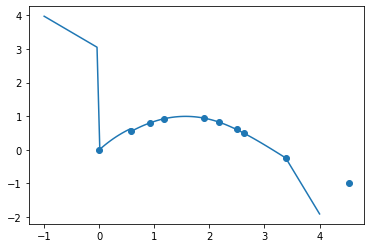

In [36]:
import matplotlib.pyplot as plt

plt.plot(x_plot, spline)
plt.scatter(x_data, y_data)
plt.show()